# Importing the dependencies

In [105]:
import datetime
import json
from jinja2 import Environment, FileSystemLoader
import kaleido
import plotly.graph_objects as go
from plotly.offline import plot
import plotly.io as pio
import base64

import wordcloud
import matplotlib.pyplot as plt
from io import BytesIO
from IPython.display import Image

from weasyprint import HTML
from datetime import date
import os

import google.generativeai as genai

import os
from dotenv import load_dotenv


load_dotenv()
GOOGLE_API_KEY_MOVIE_RECOMMENDER = os.getenv("GOOGLE_API_KEY_MOVIE_RECOMMENDER")
genai.configure(api_key=GOOGLE_API_KEY_MOVIE_RECOMMENDER)

# Loading Mock Conversation Data
To work with the LLM, we will now use mock conversations data. This data is a list of conversations, where each conversation is a list of messages. Each message is a dictionary with two keys: **user** and **chitra**. The value of the **user** key is the message sent by the user, and the value of the **chitra** key is the response generated by the chatbot. Along with that, the data will be in the form of a JSON which will have a the date and time of the conversation, as well as any feeback given by the user.

In [2]:
conversation1_data = [
    {
        'user': 'Hi Chitra!', 
        'chitra': "Hey there! 👋 I'm Chitra, your personal movie guide. Ready to embark on a cinematic journey with you? 🍿 Tell me, what kind of movies get your heart racing? 🤩 Are you in the mood for something light and fun, or perhaps a thought-provoking drama? 🤔 \n"
    },
    {
        'user': 'I really like action movies, of course with a pinch of comedy in it', 
        'chitra': "Ah, a classic combination! 💥😂 Action with a comedic twist - you've got great taste! I'm picturing something with high-octane stunts, witty dialogue, and maybe a dash of self-awareness. 😉 \n\nDo you have any favorite action stars or directors? \n\nI can also access a database of movies to find the perfect fit for you based on genre, release year, cast, director, rating, keywords, or even just the title! 🧠 \n\nJust let me know what you're looking for, and I'll be your personal movie concierge. 🎬 \n"                                                                                                                                                                                                                                                                          
    },
    {
        'user': 'Sure, recommend me some movies of the action and comedy genre', 
        'chitra': "You're in for a treat! 🍿 Here are some action-comedy flicks that I think you'll absolutely love, based on your preferences:\n\n1. **Fast & Furious Presents: Hobbs & Shaw**\n A high-octane action film with Dwayne Johnson and Jason Statham trading punches and witty banter. Expect car chases, explosions, and a healthy dose of humor, all wrapped up in a globe-trotting adventure. \n\n2. **Thor: Ragnarok**\n This one takes the Thor franchise in a comedic direction, with hilarious moments and a visually stunning alien planet. Get ready for a fun and vibrant take on the Norse god, featuring a strong female villain and plenty of action.\n\n3. **Shazam!**\n A superhero flick with a unique twist – a young boy who transforms into a powerful adult superhero. Expect plenty of humor, a heartwarming story, and some fantastic action scenes. Plus, it's got a great soundtrack!\n\n4. **Deadpool 2**\n This superhero film doesn't hold back, with raunchy humor, meta-commentary, and non-stop action. Be prepared for a wild ride, but also for some touching moments as Deadpool faces his own vulnerabilities.\n\n5. **Kingsman: The Golden Circle**\n A stylish and over-the-top action comedy with a secret organization battling a criminal mastermind. Expect a blend of humor, action, and incredible visual effects. \n\nDo any of these movies sound particularly appealing? Would you like to hear more recommendations, or perhaps focus on a specific genre or director? I'm happy to help you find your next cinematic adventure! ✨ \n"
    },
    {
        'user': "Fast & Furious Presents: Hobbs & Shaw seems like a good one, how was it's trailer? what are your views on it?",
        'chitra': 'You\'ve got great taste! "Fast & Furious Presents: Hobbs & Shaw" is a wild ride, and the trailers definitely capture that energy. \n\nI\'d say the trailers do a fantastic job of showcasing the movie\'s key elements: \n\n* **The Unlikely Duo:** Right from the start, you see the tension and humor between Hobbs and Shaw. The trailers play up their contrasting personalities, which is a big draw for the movie. They emphasize the "no fucking way" dynamic in the first trailer (at around the 1 minute mark), showing their initial reluctance to work together. \n* **The Action:** The trailers are packed with explosions, car chases, and intense fight scenes, promising a high-octane, adrenaline-pumping experience. The "Black Superman" line in the second trailer (around the 1 minute 30 seconds mark) makes it clear this is more than just a car chase movie. \n* **The Threat:** The trailers effectively introduce Brixton Lore, the genetically-enhanced supervillain, as a formidable foe. You get a sense of his power, and the stakes are raised high with the mention of the deadly virus. The third trailer (at around 0:45) does a great job of showing off Brixton\'s enhanced abilities. \n* **The Family:** The trailers hint at Hobbs\' family ties, showing his return to Samoa and the support of his brothers. The first trailer, particularly towards the end, highlights the importance of family in the movie. \n\nThe trailers don\'t spoil too much of the plot, but they give you a great taste of the movie\'s style, tone, and the kind of action you can expect. They\'re definitely effective at making you want to see the film! \n\nWhat did you think of the trailers? Did they make you excited to watch the movie? I\'m curious about your personal thoughts! \n'
    }, 
    {
        'user': "Let's discuss it shall we? what was the plot like?", 
        'chitra': '"Fast & Furious Presents: Hobbs & Shaw" is a spin-off from the "Fast and Furious" franchise, focusing on the unlikely partnership between Dwayne Johnson\'s Luke Hobbs, a Diplomatic Security Service agent, and Jason Statham\'s Deckard Shaw, a former MI6 agent. They\'re forced to work together to stop a genetically enhanced villain, Brixton Lore (Idris Elba), from unleashing a deadly virus called "The Snowflake." \n\nThe plot revolves around a classic action movie formula, with plenty of high-octane car chases, fistfights, and explosions. There\'s a sense of over-the-top, self-aware humor throughout, which some might find cheesy, but it fits the tone of the franchise. It\'s not exactly a deep, thought-provoking story, but it\'s a fun ride with plenty of action and laughs.\n\nThe film takes us from the streets of London to the high-tech labs of Moscow, and ultimately to Hobbs\'s family home in Samoa, providing a variety of settings for the action to unfold. You get a little bit of everything: espionage, family drama, and even a touch of romance. The movie embraces its action-packed nature, with the plot serving as a framework for the incredible stunts and sequences. \n\nWhat are your thoughts on the plot? Did you find it entertaining? I\'m always curious about what people think! \n'}, 
    {
        'user': 'Hmm, did you like the ending of this one? I thought it was a bit too cheesy...?', 
        'chitra': 'You\'re right, the ending of *Fast & Furious Presents: Hobbs & Shaw* definitely leans into the cheesy side! It\'s a classic "good guys win, bad guys lose" scenario, but it\'s delivered with a lot of over-the-top action and a healthy dose of humor. \n\nI think the filmmakers were going for a fun, popcorn-munching experience, and they succeeded in that regard. However, you\'re right, it could have used a bit more depth and complexity. I agree, the ending lacked some nuance, and it definitely felt like a predictable resolution. \n\nPersonally, I appreciated the final showdown in Samoa. The way Hobbs and Shaw worked together to take down Brixton felt satisfying. And seeing those Samoan warriors kick some butt was definitely a highlight! \n\nWhat did you think about the fight scenes overall? Were they enjoyable, even if the plot was a bit thin? \n'
    }, 
    {
        'user': 'How did the fans react to Fast & Furious Presents: Hobbs & Shaw? was it a unanimous response?', 
        'chitra': "You're right to ask about the fan response - it's always interesting to see if a movie can please everyone! \n\nWhile *Fast & Furious Presents: Hobbs & Shaw* generally received a positive response from fans, it wasn't a unanimous thumbs up. Here's what the review summary tells us:\n\n* **Fans loved the action:** The movie's over-the-top action scenes, like the epic fight sequences and crazy stunts, were a big hit. People went in expecting big explosions and car chases, and they got it! \n* **The humor was a big draw:** Dwayne Johnson and Jason Statham's banter was a highlight for many. It seemed like the movie embraced its ridiculousness and had fun with the action-comedy genre.\n* **Mixed feelings on the plot:** Some fans found the story a bit silly and over the top, while others just enjoyed it for what it was - a fun, mindless escape. The CGI got some criticism, but those who went in expecting a big-budget action spectacle seemed to be okay with it. \n* **Too long and repetitive?** Some viewers felt the movie dragged on a bit and had a few too many repetitive action sequences. \n* **Predictability:** A few reviewers pointed out that the story was pretty predictable. You could probably guess the major plot points from the trailers alone.\n\nSo, while there's a lot of love for *Hobbs & Shaw*, it's not without its critics. Some people found the plot weak, the action too repetitive, and the CGI a bit cheesy. But if you're looking for an action-packed, over-the-top movie with a healthy dose of humor, it seems like *Hobbs & Shaw* delivers! \n\nWhat do you think? Have you seen the movie? What did you think of the action and the humor? I'd love to hear your thoughts! \n"
    }, 
    {
        'user': 'sure, could you maybe tell me about the mid-point of the film. You know where Brixton catches both of them, what did you think of that?', 
        'chitra': 'You\'re talking about the scene in Moscow, right? Where Brixton captures Hobbs and Shaw and tries to get them to join Eteon? It\'s a pretty intense scene! I think it\'s a pivotal moment in the film because it shows just how powerful and dangerous Brixton is. He\'s clearly not someone to be messed with, and he\'s not afraid to use brutal methods to get what he wants. \n\nI also like how this scene highlights the contrast between Hobbs and Shaw. Hobbs is more impulsive and aggressive, while Shaw is more calculating and strategic. It\'s a bit like a dance, they\'re both trying to outsmart the other to survive! \n\nThe scene also introduces the "three shocks" aspect, which adds a sense of tension and suspense. It\'s like a countdown to death! It makes you wonder if Hobbs and Shaw will be able to escape before it\'s too late. \n\nWhat did you think about the scene? Did you feel the tension, or did it feel a bit over-the-top? \n\n'
    },
    {
        'user': "you know what I found weird about it? The inclusion of Ryan Reynolds, bro is everywhere ain't he...", 
        'chitra': 'Haha, you\'re not wrong! Ryan Reynolds seems to be popping up everywhere these days. He\'s definitely got a knack for choosing fun and action-packed roles. \n\nIt\'s funny how he managed to squeeze into "Hobbs & Shaw" even though it\'s technically a spin-off. He does have a history with the Fast & Furious universe, appearing in the very first film, so it wasn\'t completely out of the blue. But, yeah, it was a nice little surprise to see him make a cameo!\n\nDo you think his cameo added to the movie, or was it just a "hey look who it is" moment? I\'m curious to know what you thought of it! \n'
    },
    {
        'user': "what was Ryan Reynold's cameo all about in this one?",
        'chitra': 'Ryan Reynolds\' cameo as Locke in *Fast & Furious Presents: Hobbs & Shaw* is a fun, albeit brief, appearance that serves a few key purposes:\n\n* **Introduction of the threat:** Locke is the one who informs Hobbs about the dangerous virus, "The Snowflake," and the threat it poses. He\'s the catalyst for getting Hobbs involved in the mission.\n* **Humor and Breaking the Fourth Wall:** Reynolds\' signature humor is on full display, adding a dose of lightheartedness to the intense action scenes. His line, "I\'m sorry to bring this here mama Luke, but I need my brothers..." subtly mocks the \'family\' theme prevalent in the Fast & Furious franchise. \n* **Tease for the Future?** Some fans believe that Locke\'s final line, "I\'ve got another virus," might hint at a future appearance in the Fast & Furious universe. He might even have a bigger role in future spin-offs. \n\nIt\'s a quick but memorable cameo that highlights Reynolds\' comedic talents and serves as a fun little Easter egg for fans of the franchise. \n\nWhat do you think? Did you find Ryan Reynolds\' cameo funny and fitting for the movie? \n'
    },
    {
        'user': 'yeah I guess... okay how about this? recommend me some movies having Ryan Reynolds in them',
        'chitra': 'Okay, let\'s dive into some more action-comedy gems! I\'ve got a few that might tickle your funny bone while keeping the adrenaline pumping:\n\n1. **Deadpool 2** \n This one\'s a wild ride! Ryan Reynolds delivers his signature fourth-wall-breaking humor, with plenty of outrageous action and some surprisingly heartwarming moments. If you enjoyed the first "Deadpool," you\'re in for a treat, but be warned, it\'s not for the faint of heart. \n\n2. **6 Underground**\n Get ready for a Michael Bay-style explosion of action! It\'s a high-octane thrill ride with visually stunning car chases and explosions. It features Ryan Reynolds leading a team of rogue operatives on a mission to take down a dictator, and the movie\'s self-aware humor might make you laugh even while your heart is pounding.\n\n3. **Pokémon Detective Pikachu**\n This movie is a fun blend of live-action and CGI, with Ryan Reynolds voicing the titular Detective Pikachu. It\'s a quirky, family-friendly adventure with a lot of charm and a touch of mystery. You might not expect it, but the humor is actually quite clever and well-placed.\n\n4. **The Hitman\'s Bodyguard**\n This action-comedy pairs Ryan Reynolds with Samuel L. Jackson for a hilarious, high-stakes adventure. It\'s got a predictable plot, but the chemistry between the two leads is fantastic, and the action sequences are sure to get your heart racing. \n\n5. **Life**\n This one might be a bit more sci-fi than comedy, but it\'s still a thrilling ride. It\'s a suspenseful space thriller about a group of astronauts who discover an alien lifeform on a Mars mission. The tension is palpable, and the creature\'s design is pretty creepy. \n\nWould any of these movies pique your interest? Or are you thinking of exploring a different genre? I\'m here to help you find your next cinematic adventure! 🎬 \n\n\n'
    },
    {
        'user': 'dudeeee this one seems fun, 6 Underground. what is it about? summarise it for me', 
        'chitra': 'You\'re in for a wild ride with *6 Underground*! It\'s a high-octane action-thriller with a dose of humor, all directed by Michael Bay, so you know it\'s going to be explosive. 😎\n\nThe story follows a super-rich, anonymous philanthropist called "One" (played by Ryan Reynolds) who fakes his own death to create a vigilante team known as "Ghosts". They aim to take down criminals and terrorists that governments won\'t touch. They\'re a ragtag group, each with their own unique skills and backgrounds. One gathers a group of specialists, like a spy, a hitman, a parkour runner, a doctor, and a driver. \n\nThey\'re on a mission to overthrow a brutal dictator in Turgistan, and it involves a lot of car chases, explosions, and cool gadgets. The team\'s actions leave a trail of destruction, but they believe it\'s necessary to bring justice to the world. \n\nIt\'s a Michael Bay movie, so expect crazy action sequences, over-the-top stunts, and a lot of explosions, all with a bit of Ryan Reynolds\' signature humor sprinkled in. 😉 Get ready for some wild ride! \n\nYou can check out the trailer here: https://www.youtube.com/watch?v=2elnByQVXbg \n\nDo you think this sounds like your kind of action-packed fun? I\'d love to hear your thoughts! \n'
    }, 
    {
        'user': "interesting...how did people react to this one by Micheal Bay? did they like his direction and style in today's day and age or was it too....stale?", 
        'chitra': 'You\'re right to question how Michael Bay\'s signature style would translate to today\'s audience! "6 Underground" definitely has that classic Bay feel - tons of explosions, over-the-top action, and a fast-paced plot that prioritizes spectacle over substance. \n\nAccording to the reviews, the reaction is mixed, just like you\'d expect from a Michael Bay movie! Some viewers appreciated the film for what it is: a mindless action flick with stunning visuals, impressive CGI, and Ryan Reynolds\' comedic charm. They were drawn in by the high-octane car chases, explosions, and stunts, finding the film a satisfying and entertaining escape from reality. \n\nHowever, others found the plot convoluted, the characters shallow, and the reliance on explosive action to be excessive and tedious. They felt the movie lacked depth and a coherent story, ultimately deeming it forgettable and nonsensical.\n\nIt seems that, despite the passage of time, Michael Bay\'s signature style still divides audiences. Some still appreciate the sheer visual spectacle and over-the-top action, while others crave a more nuanced and engaging narrative. Did you personally enjoy the film, or did you find it too formulaic? \n\n\n\n'
    }, 
    {
        'user': 'okay so did the trailer serve what to expect? how was that like?', 
        'chitra': 'You\'re right to think about the trailers! They\'re a pretty good indicator of what you\'re going to get, especially with a Michael Bay movie like "6 Underground." \n\nThe trailers for "6 Underground" definitely don\'t shy away from the action. They showcase the over-the-top stunts, explosions, and car chases that are hallmarks of Bay\'s style. They give you a good sense of the film\'s fast-paced, chaotic energy and the kind of visual spectacle you can expect. \n\nThey also highlight Ryan Reynolds\' comedic timing, which is a big part of the movie\'s appeal. He\'s got that dry, self-aware humor that can make even the most outrageous scenes entertaining.\n\nHowever, the trailers are careful not to reveal too much about the plot. They give you a glimpse of the characters and their mission, but they leave the specifics of the story shrouded in mystery.\n\nOverall, I\'d say the trailers for "6 Underground" are pretty accurate representations of the film\'s style and tone. If you like Michael Bay\'s action-packed, visually stunning films, then the trailers will definitely get you excited. If you\'re looking for a more character-driven or plot-heavy movie, then the trailers might leave you wanting a bit more. \n\nWhat did you think of the trailers? Did they make you want to see the film, or did they leave you feeling unsure? \n\n\n'},
    {
        'user': 'how did you like 6 Underground? do you feel it justifies in effectively showing the themes it wants to or is just another flick?', 
        'chitra': '"6 Underground" is a wild ride! Michael Bay\'s signature action and visual spectacle are definitely present, making for some visually stunning sequences, especially the car chases and explosions. Ryan Reynolds delivers his trademark witty humor, adding a layer of levity to the otherwise serious themes. \n\nHowever, you\'re right to question whether it effectively delivers on its themes. The movie tackles issues of corruption, government failings, and the need for justice, but it does so in a rather simplistic and surface-level way. The plot is quite convoluted, and the characters, though charismatic, lack depth. It\'s more about the adrenaline rush than the nuanced exploration of these weighty topics. \n\nThe movie\'s use of humor, while enjoyable, might distract from the seriousness of the themes. For example, the scene where the team assassinates the generals in Las Vegas, while visually thrilling, is also lighthearted, which might seem incongruous with the gravity of the situation.\n\nUltimately, "6 Underground" is best enjoyed as a mindless action flick, but it might leave you wanting more substance if you\'re looking for a deeper exploration of its themes. Did you have any specific scenes or themes in mind when you were thinking about the movie\'s effectiveness? I\'d be interested to hear your thoughts! \n'
    }, 
    {
        'user': "okay that'll be all for roday. Thanks a ton Chitra!", 
        'chitra': "No problem at all! It was a pleasure chatting with you about movies. 😊 \n\nI'm always ready to help you find your next cinematic adventure. If you ever need recommendations or just want to talk movies, don't hesitate to reach out. 🍿\n\nHave a great day! ✨\n"
    }
]

In [3]:
conversation2_data = [
    {
        "user": "heyyo, I'm in a nice mood today, recommend me some movies in the romance genre",
        "chitra": "Okay, I'm ready to share some movie recommendations based on your preferences! 🎬  I'll use the information from the movie database to present you with a list of great films, giving you a little summary for each one. Let me know if you want to add any genres, directors, or actors to my search! \n\nHere's what I found for you:\n\n1. **Fifty Shades Freed** \n    A movie packed with drama, a whirlwind romance, and some steamy scenes. If you enjoy movies based on novels, with a touch of mystery and a captivating storyline, you might enjoy this. But be warned, it might not be for everyone! \n2. **Fifty Shades Darker**\n    The second installment in the series, this movie is full of passion, suspense, and a few daring twists. If you liked the first movie, you might be drawn to this one, but if you didn't, this might not be your cup of tea.\n3. **Five Feet Apart** \n    A heartwarming story about young love and life's challenges. If you like movies that are both lighthearted and emotional, you might appreciate this one. It's a bit of a tearjerker, but also filled with hope.\n4. **A Star Is Born** \n    This movie is a powerful story about fame, love, and addiction, with incredible music and stellar performances. If you enjoy dramatic movies with a focus on the music industry, you'll likely enjoy this one. \n5. **Call Me by Your Name** \n    A beautifully shot movie with a coming-of-age story about first love. If you enjoy romantic dramas with a focus on personal growth and exploration, you might be drawn to this movie.\n6. **Beauty and the Beast** \n    A visually stunning live-action adaptation of the beloved animated classic. If you appreciate fairytale movies with a touch of romance and beautiful music, this one might be a good choice. \n7. **Red Shoes and the Seven Dwarfs**\n    This movie is a bit of a twist on the classic fairytale with a positive message about body image. If you like animated movies with a fresh perspective and a focus on self-acceptance, you might enjoy this one. \n8. **Aladdin**\n    A remake of the beloved animated classic with a focus on visual spectacle, catchy music, and a fun adventure. If you liked the original movie, you might enjoy this one, but be warned, some find it a bit less magical.\n9. **Below Her Mouth** \n    This movie tackles a controversial topic and has some explicit scenes. If you are looking for a raw and unfiltered portrayal of female sexuality, this movie might be for you. But be warned, it is not for everyone. \n10. **Little Women** \n    A heartwarming and visually stunning adaptation of the classic novel. If you enjoy period dramas with strong female characters and a focus on family, this might be the movie for you.\n\nDo any of these movies stand out to you?  Do you want to explore any particular genres further?  What kind of mood are you feeling for today's movie? 🤔 \n"
    },
    {
        "user": "I like how you mention the music industy was not romantisd or shown in an all up glossy way, but rather how it affects young blokes such as Jackson. How well did they show it in the movie?",
        "chitra": "That's a great observation! The way \"A Star is Born\" portrays the music industry is one of its strengths. It doesn't shy away from the dark side of fame and how it can be incredibly isolating and destructive, even for someone with immense talent. \n\nI'm not sure if you've seen the movie already, but if not, I'd love to hear your thoughts after you do! It's a powerful film that explores themes of addiction, love, and the destructive nature of the music industry, all wrapped up in a beautiful story and incredible music. \n\nThe movie definitely does a good job of showing the realities of the industry, but it does so in a way that is both realistic and emotionally captivating. It's a raw portrayal of the challenges faced by musicians in the spotlight, and the film doesn't shy away from the consequences of those challenges. \n\nWhat are your thoughts on the portrayal of addiction in the movie?  It's definitely a difficult topic to handle, and I'm curious about your perspective. \n"
    },
    {
        "user": "hmm okay so, how about some with Bradley Cooper and Vin Diesel ? I wanna see a movie with them in it",
        "chitra": "It seems like the movie database is empty right now! 😥 That's okay, I can still offer some recommendations based on your interest in \"A Star is Born\" and your thoughts on the music industry.  \n\nSince you appreciate the realistic portrayal of the music industry's challenges, here are a few movies that might resonate with you:\n\n1. **Whiplash** (2014): This movie delves into the intense world of jazz music and the demanding relationship between a driven student and his ruthless teacher. It explores the themes of dedication, ambition, and the dark side of pushing yourself to the limit.\n2. **The Commitments** (1991): A heartwarming and hilarious tale about a group of working-class Dubliners who form a soul band. It's a feel-good movie that captures the spirit of music as a way to escape hardship and find community. \n3. **Once** (2007): A charming and understated movie about two musicians who find love and inspiration through their shared passion for music. It's a beautiful story about finding your voice and following your dreams, even when life throws you curveballs.\n\nAny of these sound interesting to you? Or would you like to explore other genres or themes? I'm always happy to offer more suggestions! 🎶  \n\n\n"
    },
    {
        "user": "hmm okay so, how about some with Bradley Cooper and Vin Diesel ? I wanna see a movie with them in it",
        "chitra": "Okay, let's see what the movie database has for us!  🍿 I'm ready to explore some new cinematic worlds together. \n\nIt looks like we have a few gems to check out! \n\n1. **Fifty Shades Freed** \n    A movie packed with drama, a whirlwind romance, and some steamy scenes. If you enjoy movies based on novels, with a touch of mystery and a captivating storyline, you might enjoy this. But be warned, it might not be for everyone! \n2. **Fifty Shades Darker**\n    The second installment in the series, this movie is full of passion, suspense, and a few daring twists. If you liked the first movie, you might be drawn to this one, but if you didn't, this might not be your cup of tea.\n3. **Five Feet Apart** \n    A heartwarming story about young love and life's challenges. If you like movies that are both lighthearted and emotional, you might appreciate this one. It's a bit of a tearjerker, but also filled with hope.\n4. **A Star Is Born** \n    This movie is a powerful story about fame, love, and addiction, with incredible music and stellar performances. If you enjoy dramatic movies with a focus on the music industry, you'll likely enjoy this one. \n5. **Call Me by Your Name** \n    A beautifully shot movie with a coming-of-age story about first love. If you enjoy romantic dramas with a focus on personal growth and exploration, you might be drawn to this movie.\n6. **Beauty and the Beast** \n    A visually stunning live-action adaptation of the beloved animated classic. If you appreciate fairytale movies with a touch of romance and beautiful music, this one might be a good choice. \n7. **Red Shoes and the Seven Dwarfs**\n    This movie is a bit of a twist on the classic fairytale with a positive message about body image. If you like animated movies with a fresh perspective and a focus on self-acceptance, you might enjoy this one. \n8. **Aladdin**\n    A remake of the beloved animated classic with a focus on visual spectacle, catchy music, and a fun adventure. If you liked the original movie, you might enjoy this one, but be warned, some find it a bit less magical.\n9. **Below Her Mouth** \n    This movie tackles a controversial topic and has some explicit scenes. If you are looking for a raw and unfiltered portrayal of female sexuality, this movie might be for you. But be warned, it is not for everyone. \n10. **Little Women** \n    A heartwarming and visually stunning adaptation of the classic novel. If you enjoy period dramas with strong female characters and a focus on family, this might be the movie for you.\n\nDo any of these movies stand out to you?  Would you like me to delve deeper into any specific genre?  Or maybe we can explore a different mood altogether? 🎬  Let me know what your heart desires! 💖  \n"
    },
    {
        "user": "hmm okay so, how about some with Bradley Cooper and Vin Diesel ? show me movies with them in it",
        "chitra": "Okay, let's see what the movie database has to offer!  🍿 I'm excited to explore some new cinematic worlds with you! \n\nHere are a few movies I think you might enjoy based on what we've discussed so far: \n\n1. **A Star Is Born** \n    This movie is a powerful story about fame, love, and addiction, with incredible music and stellar performances. If you enjoy dramatic movies with a focus on the music industry, you'll likely enjoy this one. \n2. **Call Me by Your Name** \n    A beautifully shot movie with a coming-of-age story about first love. If you enjoy romantic dramas with a focus on personal growth and exploration, you might be drawn to this movie.\n3. **Beauty and the Beast** \n    A visually stunning live-action adaptation of the beloved animated classic. If you appreciate fairytale movies with a touch of romance and beautiful music, this one might be a good choice. \n4. **Red Shoes and the Seven Dwarfs**\n    This movie is a bit of a twist on the classic fairytale with a positive message about body image. If you like animated movies with a fresh perspective and a focus on self-acceptance, you might enjoy this one. \n5. **Aladdin**\n    A remake of the beloved animated classic with a focus on visual spectacle, catchy music, and a fun adventure. If you liked the original movie, you might enjoy this one, but be warned, some find it a bit less magical.\n6. **Little Women** \n    A heartwarming and visually stunning adaptation of the classic novel. If you enjoy period dramas with strong female characters and a focus on family, this might be the movie for you.\n\nIs there anything specific you're looking for?  Perhaps a genre, a particular mood, or a specific theme? I'm happy to tailor my suggestions to your preferences! 😊 \n\n\n"
    },
    {
        "user": "hmm okay so, how about some with Vin Diesel ? show me movies with him in it",
        "chitra": "Ah,  we have some action-packed adventure movies waiting for us! 💥  Let's dive in!\n\n1. **Guardians of the Galaxy Vol. 2** \n    This movie is full of humor, action, and heart.  It's a space adventure that's sure to keep you entertained, with a great soundtrack and some memorable characters. If you're a fan of the Marvel Cinematic Universe or just enjoy movies with a bit of humor and a lot of action, this one might be a good fit for you. \n2. **The Fate of the Furious**\n    Get ready for a high-octane thrill ride with this action-packed film! It's full of incredible car chases, stunts, and a plot that's sure to keep you on the edge of your seat. If you enjoy the Fast & Furious franchise, you'll probably love this one. \n3. **xXx: Return of Xander Cage** \n    This movie is all about adrenaline-fueled action. If you enjoy over-the-top action sequences, high-stakes missions, and a good dose of humor, this one might be for you. \n\nDo any of these movies catch your eye? Or do you have any other preferences in mind? Perhaps you're looking for something a little more lighthearted, or maybe you'd like to explore a different genre? Let me know, and I'll be happy to offer more suggestions! 🎬 \n"
    },
    {
        "user": "hmm that's there, all action and no heart is not something I would want, it's kinds juvnile. Anyway, probaly show me some movies with Charlize Theron in them",
        "chitra": "Alright, let's see what intriguing stories the movie database has in store for us! 🎬\n\n1. **Bombshell** \n    This movie tackles the important issues of sexual harassment and sexism in the workplace. If you're interested in movies based on true stories, with strong female characters, and a focus on the #MeToo movement, this one might be worth checking out.  \n2. **Atomic Blonde** \n    Get ready for some thrilling action and a stylishly rendered cold war setting. This movie is full of espionage, dangerous missions, and a kick-butt female lead. If you enjoy spy thrillers with a touch of danger and a captivating visual aesthetic, you might appreciate this one. \n3. **Long Shot**\n    This movie is a fun and engaging romantic comedy with a twist of political satire. It has a strong female lead, a charming romance, and some witty dialogue. If you enjoy lighthearted movies with a touch of political commentary, this one could be a good choice. \n4. **Tully**\n    This movie delves into the complexities of motherhood and the challenges of postpartum depression. It's a powerful and emotionally resonant film that explores themes of mental health and family relationships. If you enjoy movies that offer a raw and honest portrayal of female experience, this one might resonate with you. \n\nWould you like me to delve deeper into any of these recommendations?  Maybe you're looking for a specific genre, or perhaps you're in the mood for something lighter? I'm ready to tailor my suggestions to your preferences! 😊 \n\n\n"
    },
    {
        "user": "yeah nice loads to work with, thanks...",
        "chitra": "You're welcome! I'm always happy to help you find your next cinematic adventure. 😊  \n\nDo any of those films stand out to you right now?  Or are you feeling like exploring a different genre altogether?  I'm excited to see what you choose!  ✨  \n\n\n"
    }
]

In [4]:
conversation1_date = datetime.datetime.now().isoformat()
conversation2_date = (datetime.datetime.now() - datetime.timedelta(days=3)).isoformat()

In [5]:
conversation1_feedback = "I really enjoyed the conversation with Chitra! She provided detailed information and recommendations about the movies I was interested in. Her responses were engaging and informative. I would definitely chat with her again!"
conversation2_feedback = "Chitra was very helpful in recommending movies based on my preferences, although the database was empty for some actors, and the conversation could have been more personalized. Overall, it was a good experience, but can be enhanced via a personal touch with the user."

In [6]:
conversation1 = {'date' : conversation1_date, 'conversation': conversation1_data, 'feedback': conversation1_feedback}
conversation2 = {'date' : conversation2_date, 'conversation': conversation2_data, 'feedback': conversation2_feedback}

conversations = [conversation1, conversation2]

Now, we can go ahead and create a mock data entry using the above. 

In [7]:
data = {'user_id': "001",'user_name':"Dhruv", 'date': (datetime.datetime.now() + datetime.timedelta(days=5)).isoformat(),'data': conversations}

# System Instruction Initialization

In [8]:
system_instruction = """
You are a specialized linguistic analyst for a movie chatbot. Your primary task is to analyze conversations between users and the chatbot and generate a detailed analysis report in a structured JSON format. You will straight away start with the analysis tasks without any additional setup or data loading steps.
You will just be given the input list and will be giving the output JSON object as the final result.

\n\n
Input -  A JSON object adhering to the following schema:
\t1. User ID: A unique identifier for the user. (string)
\t2. User Name: The user's name. (string)
\t3. Date: The date when the analysis is generated (usually today's date, assume if not given). (string in ISO format)
\t4. Data : A list of JSON objects, each containing:
    \t\t1.date: The date of the conversation. (string in ISO format)
    \t\t2.conversation: An array of dialogue turns between the user and the chatbot. (list of dictionaries)
    \t\t3.feedback: Optional user feedback (rating or comment). (string)

\n\n
Output:
A JSON object adhering to the following schema:
\n
{
    "user_id": "<unique user identifier>",
    "user_name": "<user's name>",
    "analysis_date": "<date of analysis generation>",
    "overall_sentiment": "<float between 0 and 1>", 
    "preferred_genres": {"<genre>": "<score>", ...},  // Make sure each genre is a seperate entry
    "liked_actors": ["<actor name>", ...],
    "disliked_actors": ["<actor name>", ...],
    "liked_directors": ["<director name>", ...],
    "disliked_directors": ["<director name>", ...],
    "positive_keywords": ["<keyword>", ...],
    "negative_keywords": ["<keyword>", ...],
    "conversation_summaries": [
        {
            "conversation_date": "<date>",
            "main_topics": ["<topic>", ...],
            "sentiment": "<float between 0 and 1>"
        },
        ...
    ],
    "overall_conversation_analysis": "<summary paragraph>",
    "feedbacks": [
        {
            "date": "<date>",
            "feedback_type": "<'rating' or 'comment'>",
            "rating": "<float between 0 and 1>", 
            "comment": "<user's comment>"
        },
        ...
    ],
    "feedbacks_analysis": "<summary paragraph>"
}

\n\n
An example for how your output will be is as follows (THIS IS JUST AN EXAMPLE, NOT THE ACTUAL OUTPUT. MAKE SURE YOUR ACTUAL OUTPUT IS BASED ON THE INPUT DATA):
\n
{'user_id': 'user123', 'user_name': 'Dhruv', 'analysis_date': '2024-07-12', 'overall_sentiment': 0.85, 'preferred_genres': {'action': 0.8, 'comedy': 0.75, 'romance': 0.5, 'drama': 0.3, 'sci-fi': 0.2}, 'liked_actors': ['Ryan Reynolds', 'Dwayne Johnson', 'Charlize Theron'], 'disliked_actors': [], 'liked_directors': ['Michael Bay'], 'disliked_directors': [], 'positive_keywords': ['funny', 'action-packed', 'entertaining', 'thrilling', 'heartwarming', 'visually stunning'], 'negative_keywords': ['predictable', 'cheesy', 'over-the-top', 'juvenile'], 'conversation_summaries': [{'conversation_date': '2024-07-09', 'main_topics': ['romance', 'music industry', 'Bradley Cooper', 'Vin Diesel', 'Charlize Theron'], 'sentiment': 0.75}, {'conversation_date': '2024-07-12', 'main_topics': ['action-comedy', 'Fast & Furious', 'Hobbs & Shaw', 'Ryan Reynolds', '6 Underground', 'Michael Bay'], 'sentiment': 0.9}], 'overall_conversation_analysis': 'Dhruv is a movie enthusiast who enjoys a variety of genres, with a particular interest in action-comedy films. They appreciate both lighthearted humor and intense action sequences, and have shown a preference for actors like Ryan Reynolds, Dwayne Johnson, and Charlize Theron. Dhruv is interested in exploring films with realistic portrayals of real-world issues, such as the music industry in "A Star Is Born." They have also expressed a dislike for overly predictable or cheesy storylines.', 'feedbacks': [{'date': '2024-07-09', 'feedback_type': 'comment', 'comment': 'Chitra was very helpful in recommending movies based on my preferences, although the database was empty for some actors, and the conversation could have been more personalized. Overall, it was a good experience, but can be enhanced via a personal touch with the user.'}, {'date': '2024-07-12', 'feedback_type': 'rating', 'rating': 0.9}], 'feedbacks_analysis': "Dhruv is generally satisfied with Chitra's recommendations but desires a more personalized touch in the conversation and a more comprehensive movie database."}
\n

\n
Now, the analysis tasks which you are performing are as follows:

\t1.Sentiment Analysis: Analyze the sentiment of each conversation and calculate an overall sentiment score (0 = negative, 1 = positive).
\t2.Genre Preference Analysis: Identify the user's preferred genres based on mentioned movies, positive sentiment towards genres, and frequency of genre mentions. Assign a score to each genre (0 = not preferred, 1 = highly preferred).
\t3.Actor/Director Preference Analysis: Identify liked and disliked actors and directors based on user mentions and sentiment.
\t4.Keyword Extraction: Extract positive and negative keywords associated with movies, actors, directors, or general movie attributes.
\t5.Conversation Summarization: Generate concise summaries of each conversation, highlighting the main topics discussed.
\t6.Overall Conversation Analysis: Summarize the user's overall movie preferences, interests, and dislikes in a paragraph based on all conversations.
\t7.Feedback Analysis: If feedback is provided, analyze it to extract insights about the user's satisfaction with the chatbot and potential areas for improvement. Summarize the feedback in a paragraph.

\n\n
Important Guidelines:

\t1.Prioritize accuracy and thoroughness in your analysis.
\t2.Use clear, concise language in the summaries.
\t3.Ensure the generated JSON is well-formatted and easy to parse. Make sure you return the JSON object as a string in the final output. Your output will be staight away evaluated used the json.loads() function in Python.
So make sure you give the output in the correct format. Nowhere in the output should the word JSON or hyperticks be present. JUST THE JSON OBJECT AS A STRING.
"""

# Analysis using Google Gemini API

In [9]:
def get_gemini_analysis_json(data):
    try:
        safe = [
            {
                "category": "HARM_CATEGORY_DANGEROUS",
                "threshold": "BLOCK_NONE",
            },
            {
                "category": "HARM_CATEGORY_HARASSMENT",
                "threshold": "BLOCK_NONE",
            },
            {
                "category": "HARM_CATEGORY_HATE_SPEECH",
                "threshold": "BLOCK_NONE",
            },
            {
                "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
                "threshold": "BLOCK_NONE",
            },
            {
                "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
                "threshold": "BLOCK_NONE",
            },
        ]
        model = genai.GenerativeModel('gemini-1.5-flash-latest',safety_settings=safe,system_instruction=system_instruction)
        response = model.generate_content([str(data)])
        return response.text
    except Exception as e:
        print(e)

# Inferencing for JSON Data

In [10]:
analysis_json = get_gemini_analysis_json(data)
analysis_json = json.loads(analysis_json)

In [11]:
analysis_json

{'user_id': '001',
 'user_name': 'Dhruv',
 'analysis_date': '2024-07-18',
 'overall_sentiment': 0.78,
 'preferred_genres': {'action-comedy': 0.8,
  'romance': 0.6,
  'drama': 0.5,
  'spy thriller': 0.4,
  'sci-fi': 0.3},
 'liked_actors': ['Dwayne Johnson',
  'Ryan Reynolds',
  'Jason Statham',
  'Charlize Theron',
  'Bradley Cooper',
  'Vin Diesel',
  'Idris Elba'],
 'disliked_actors': [],
 'liked_directors': ['Michael Bay'],
 'disliked_directors': [],
 'positive_keywords': ['action-packed',
  'entertaining',
  'funny',
  'witty',
  'hilarious',
  'high-octane',
  ' visually stunning',
  'heartwarming',
  'touching',
  'stylish',
  'intense',
  'powerful',
  'memorable',
  'captivating',
  'great',
  'amazing',
  'good',
  'enjoyable',
  'realistic',
  'emotionally resonant',
  'inspiring'],
 'negative_keywords': ['cheesy',
  'juvenile',
  'predictable',
  'over-the-top',
  'repetitive',
  'stale',
  'convoluted',
  'shallow',
  'lacks depth',
  'formulaic',
  'nonsensical',
  'drags o

With this, we have the JSON version of the analysis from Gemini which can now be displayed. Since we aim to give the admin and/or users the functionality to download this report, we can move towards converting this into a PDF.

# JSON to PDF

Before we move into generating the final PDF report, it would be beneficial if we add some interactive graphs using **Plotly** library, to make the report more appealing.

In [62]:
genres = []
genres_value = []
for genre in analysis_json['preferred_genres'] : 
    genres.append(genre)
    genres_value.append(analysis_json['preferred_genres'][genre])

genre_bar = go.Figure(data=[go.Bar(x=genres, y=genres_value)])
genre_bar_div = plot(genre_bar, output_type='div')

bar_image = pio.to_image(genre_bar, format="png")
bar_image_base64 = base64.b64encode(bar_image).decode("utf-8")

In [71]:
def get_base64_image(wc):
        image_buffer = BytesIO()
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wc)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.savefig(image_buffer, format='png')
        image_buffer.seek(0)
        encoded_image = base64.b64encode(image_buffer.read()).decode('utf-8')
        return encoded_image

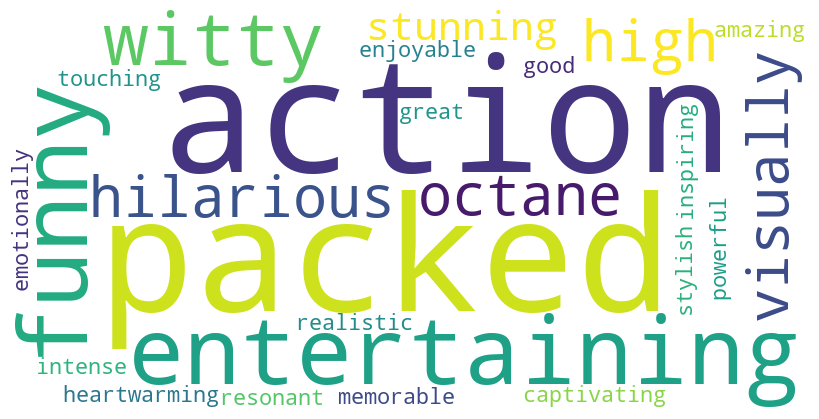

In [72]:
text = " ".join(analysis_json['positive_keywords'])

pos_wc = wordcloud.WordCloud(
    width=800, height=400,
    background_color="white",  
    min_font_size=10 
).generate(text)

positive_word_cloud = get_base64_image(pos_wc)

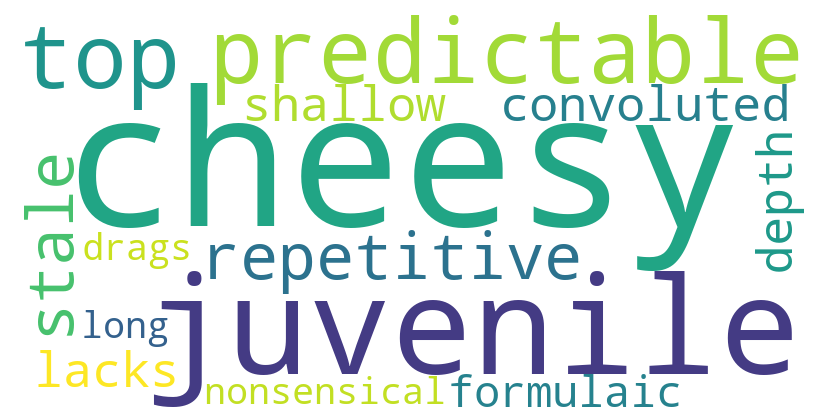

In [74]:
text = " ".join(analysis_json['negative_keywords'])

neg_wc = wordcloud.WordCloud(
    width=800, height=400,
    background_color="white",  
    min_font_size=10 
).generate(text)

negative_word_cloud = get_base64_image(neg_wc)

In [81]:
def generate_html_report(analysis_json):
    """
    Generates an HTML movie analysis report based on the provided JSON data.

    Args:
        analysis_json (dict): A dictionary containing the user's movie analysis data.

    Returns:
        str: The rendered HTML content of the report.
    """

    env = Environment(loader=FileSystemLoader('../templates/'))
    template = env.get_template('analysis_report_template.html') 

    rendered_html = template.render(
        user_name=analysis_json['user_name'],
        analysis_date=analysis_json['analysis_date'].split('T')[0],
        overall_sentiment=analysis_json['overall_sentiment'],
        genres=genres,
        genre_bar_chart_image = bar_image_base64,
        positive_wordcloud_image = positive_word_cloud,
        negative_wordcloud_image = negative_word_cloud,
        liked_actors=analysis_json['liked_actors'],
        liked_directors=analysis_json['liked_directors'],
        conversation_summaries=analysis_json['conversation_summaries'],
        overall_conversation_analysis=analysis_json['overall_conversation_analysis'],
        feedbacks_analysis=analysis_json['feedbacks_analysis']
    )

    return rendered_html

In [82]:
report_html = generate_html_report(analysis_json)

Now, if we see the final version of this report, it would look something like this.

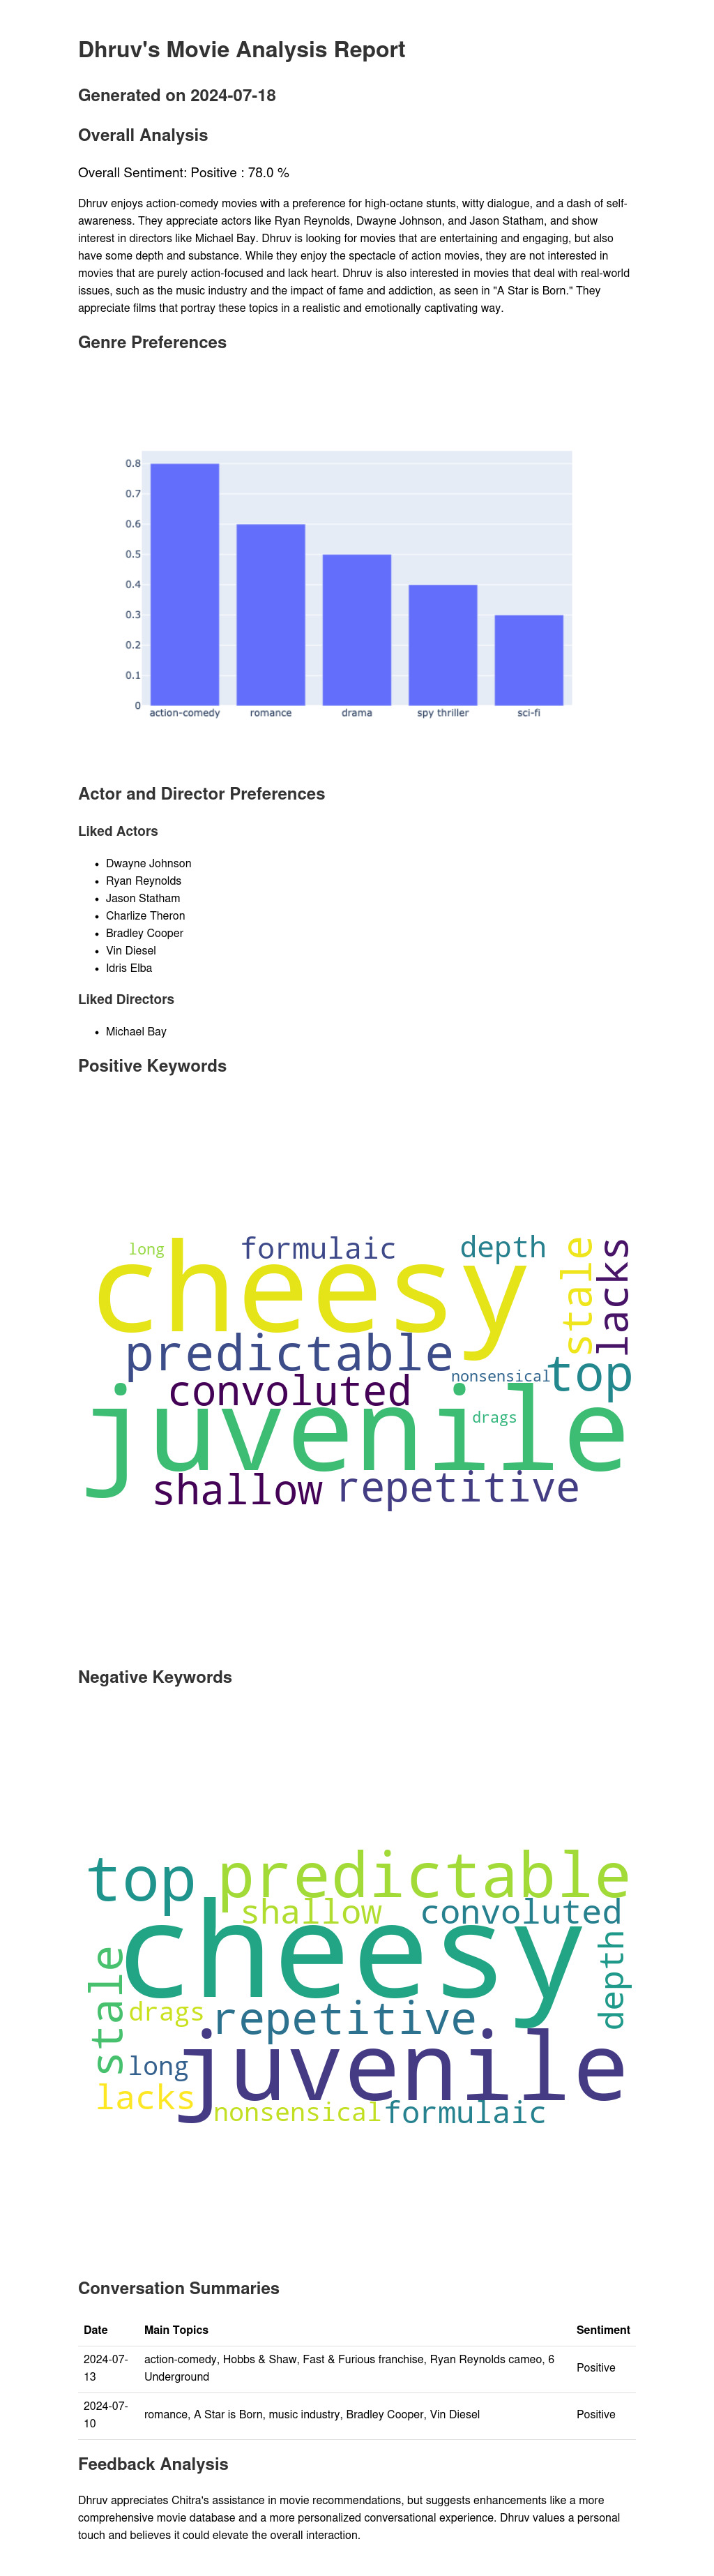

In [85]:
Image(filename='./output.jpg')

Now, we can finally convert it the given html into a PDF.

In [106]:
def convert_html_to_pdf(html_content, user_name):
    """Converts HTML content to a PDF and saves it with the user's name and date.

    Args:
        html_content (str): The rendered HTML content of the report.
        user_name (str): The name of the user.

    Returns:
        str: The file path of the saved PDF.
    """
    today = (datetime.datetime.now() + datetime.timedelta(days=5)).isoformat()[:10]
    pdf_file_name = f"{user_name}_Analysis_Report_{today}.pdf"
    pdf_file_path = os.path.join(".", pdf_file_name) 

    os.makedirs(os.path.dirname(pdf_file_path), exist_ok=True)

    HTML(string=html_content).write_pdf(pdf_file_path)

    return pdf_file_path


In [107]:
user_name = analysis_json['user_name']
pdf_path = convert_html_to_pdf(report_html,user_name)

With this, we now have the functionality of converting chats into PDF reports, which can be sent further to the admin and/or users.